In [10]:
import os
import random
import pickle
import numpy as np
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
import copy

In [11]:
class FragmentType:
    single = 1
    double = 2
    triple = 3
    total_fragments= 3

class BondType:
    CC = [1]
    CO = [2]
    CN = [1,2,3]
    CS = [1,2]
    CP = [1]
    OO = [1]
    NO = [1,2]
    NN = [2]
    SO = [1,2]
    PO = [1,2]
    
class AtomType:
  C = 1
  O = 2
  N = 3
  S = 4
  P = 5
  total_types = 2
    
class Valence:
  C = 4
  O = 2
  N = 5
  S = 6
  P = 5

class Fragment:
    def __init__(self):
        self.Gs = nx.Graph()
        self.anchors = []
        self.hashes = ""
        
    def copy(self):
        new_frag = Fragment()
        new_frag.Gs = self.Gs.copy()
        new_frag.anchors = self.anchors.copy()
        new_frag.hashes = self.hashes
        return new_frag

In [12]:
def validate_valence(atom_type, valence):
    if atom_type == AtomType.C:
        return Valence.C - valence
    elif atom_type == AtomType.N:
        return Valence.N - valence
    elif atom_type == AtomType.O:
        return Valence.O - valence
    elif atom_type == AtomType.S:
        return Valence.S - valence
    elif atom_type == AtomType.P:
        return Valence.P - valence
    else:
        return 0

def generate_all_possible_fragments(min_frag, max_frag):
    prev_frags = []
    dict_fragments = {}
    # dict_size_of_fragments = {}
    
    for num_frag in range(min_frag, max_frag+1):
        if num_frag == 1:
            new_frag = Fragment()
            
            new_frag.Gs.add_nodes_from([
                (0, {"label": AtomType.C, "anchor": 1}),
                (1, {"label": AtomType.C, "anchor": 0})
            ])
            bond = random.choice(BondType.CC)
            new_frag.Gs.add_edges_from([
                (0, 1, {"label": bond})
            ])
            new_frag.anchors = [0]
            
            hashes = nx.weisfeiler_lehman_graph_hash(new_frag.Gs, node_attr="anchor", edge_attr="label")
            new_frag.hashes = hashes
            
            dict_fragments[hashes] = new_frag
            prev_frags.append(hashes)
            # dict_size_of_fragments[hashes] = num_frag
            continue
        
        tobeadd_frags = prev_frags.copy()
        prev_frags = []
        
        for frag_key in tobeadd_frags: # key in dict_fragments
            # Add a new branch
            frag = dict_fragments[frag_key].copy()
            new_nid1 = frag.Gs.number_of_nodes()
            new_nid2 = frag.Gs.number_of_nodes() + 1
            
            frag.Gs.add_nodes_from([
                (new_nid1, {"label": AtomType.C, "anchor": 1}),
                (new_nid2, {"label": AtomType.C, "anchor": 0})
            ])
            bond = random.choice(BondType.CC)
            frag.Gs.add_edges_from([
                (new_nid1, new_nid2, {"label": bond})
            ])
            frag.anchors.append(new_nid1)
            frag.hashes = nx.weisfeiler_lehman_graph_hash(frag.Gs, node_attr="anchor", edge_attr="label")
            
            if frag.hashes not in dict_fragments:
                dict_fragments[frag.hashes] = frag
                prev_frags.append(frag.hashes)
                # dict_size_of_fragments[frag.hashes] = num_frag
            
            # Add to existing branches
            frag_iter = dict_fragments[frag_key]
            for nid in frag_iter.Gs:
                frag = dict_fragments[frag_key].copy()

                new_nid = frag_iter.Gs.number_of_nodes()

                frag.Gs.add_nodes_from([
                    (new_nid, {"label": AtomType.C, "anchor": 0})
                ])
                bond = random.choice(BondType.CC)
                frag.Gs.add_edges_from([
                    (nid, new_nid, {"label": bond})
                ])
                
                # Validate valence of nid
                valence = 0
                for edge in frag.Gs.edges(nid):
                    valence += frag.Gs.get_edge_data(*edge)["label"]
                valid_valence = validate_valence(frag.Gs.nodes[nid]["label"], valence)
                if valid_valence < 0:
                    continue
                
                frag.hashes = nx.weisfeiler_lehman_graph_hash(frag.Gs, node_attr="anchor", edge_attr="label")

                if frag.hashes not in dict_fragments:
                    dict_fragments[frag.hashes] = frag
                    prev_frags.append(frag.hashes)
                    # dict_size_of_fragments[frag.hashes] = num_frag
    
    list_fragments = list(dict_fragments.values())
    for i in range(len(list_fragments)):
        for nid in list_fragments[i].Gs:
            # list_fragments[i].Gs.nodes[nid].pop("anchor", None)
            del list_fragments[i].Gs.nodes[nid]['anchor']
    return list_fragments

def find_combinations(arr, index, num, reducedNum):
    # Base condition
    if (reducedNum < 0) or (reducedNum > 0 and index >= len(arr)):
        return
 
    # If combination is
    # found, print it
    if reducedNum == 0 and index == len(arr):
        return [tuple(arr.copy())]
    elif reducedNum == 0 and index < len(arr):
        return []
 
    # Find the previous number stored in arr[].
    # It helps in maintaining increasing order
    prev = 1 if(index == 0) else arr[index - 1]
 
    # note loop starts from previous
    # number i.e. at array location
    # index - 1
    list_combs = []
    upper_bound = int((num - index) / (len(arr) - index))
    
    for k in range(prev, upper_bound+1):
        # next element of array is k
        arr[index] = k
 
        # call recursively with
        # reduced number
        combs = find_combinations(arr.copy(), index + 1, num, reducedNum - k)
        if combs is not None:
            list_combs.extend(combs)
    return list_combs

def get_possible_combinations(cycle_size, min_comb, max_comb):
    dict_comb = {}
    for comb in range(min_comb, max_comb+1):
        all_combs = find_combinations([0]*comb, 0, cycle_size, cycle_size)
        
        convert_to_index = []
        for ec in all_combs:
            eci = [0]
                
            for i in range(comb-1):
                eci.append(eci[i] + ec[i])
                
            convert_to_index.append(tuple(eci))
                
        dict_comb[comb] = convert_to_index
    return dict_comb

In [13]:
class GraphGenerator:
  def __init__(self):
    super().__init__()

  # Generate all graphs
  def gen(self, saving_folder, min_cycle, max_cycle, min_fragments, max_fragments):
    if not os.path.exists(saving_folder):
      os.mkdir(saving_folder)
    
    if min_fragments == 0:
        min_comb = 1
    else:
        min_comb = min_fragments
        
    if max_fragments > max_cycle:
        max_comb = max_cycle
    else:
        max_comb = max_fragments
        
        
    print("GENERATIGN ALL FRAGMENTS...")
    list_all_fragments = generate_all_possible_fragments(min_fragments, max_fragments)
    
    labels = {}
    graph_count = 0
    
    for cycle_size in range(min_cycle, max_cycle+1):
        print("GENERATING CYCLIC GRAPH:", cycle_size)
        cyclic_graph = self.get_cyclic_graph_by_size(cycle_size)
        
        # Case min fragment = 0
        if min_fragments == 0:
            label = self.calculate_label(cyclic_graph, cycle_size)
            fname = "%d_%d_%d_%.3f.pkl"%(graph_count, cycle_size, 0, label)
            saving_path = os.path.join(saving_folder, fname)
            nx.write_gpickle(cyclic_graph.copy(), saving_path)

            labels[graph_count] = label
            graph_count += 1
        
        # where to put a fragment on the cyclic graph
        # {num_anchor:[list_combination]}
        combinations = get_possible_combinations(cycle_size, min_comb, max_comb) 
        
        for fragments in tqdm(list_all_fragments):
            if len(fragments.anchors) not in combinations:
                continue
                
            combination = combinations[len(fragments.anchors)]
            graphs, label = self.gen_sample(cyclic_graph.copy(), cycle_size, fragments, combination)
      
            for graph in graphs:
                num_fragments = graph.number_of_nodes() - cycle_size
                fname = "%d_%d_%d_%.3f.pkl"%(graph_count, cycle_size, num_fragments, label)
                saving_path = os.path.join(saving_folder, fname)
                nx.write_gpickle(graph, saving_path)

                labels[graph_count] = label
                graph_count += 1

    pickle.dump(labels, open("labels.pkl", "wb"))
    
  # Generate one graph
  def gen_sample(self, cyclic_graph, cycle_size, fragments, combination):
    # Merge all fragments into graph
    graphs = self.merge_fragments_to_graph(cyclic_graph, fragments, combination)
    
    # Calculate label
    label = self.calculate_label(graphs[0], cycle_size) if len(graphs) > 0 else None
    return graphs, label

  # Create synthesis label for a graph
  def calculate_label(self, graph, cycle_size):
    cycle_score = 0
    for nid in list(graph.nodes)[:cycle_size]:
        cycle_score += graph.nodes[nid]["label"]
    
    branch_score = 0
    for nid in list(graph)[cycle_size:]:
        branch_score += graph.nodes[nid]["label"]
        
    return cycle_score * 10 + branch_score * 0.1 #+ np.random.uniform(-1e-2, 1e-2)

  # Create cyclic
  def get_cyclic_graph_by_size(self, size):
    graph = nx.Graph()
    graph.add_nodes_from([
        (i, {"label": AtomType.C}) \
        for i in range(size)
    ])
    
    graph.add_edges_from([
        (i, (i+1)%size, {"label": 1}) \
        for i in range(size)
     ])
    
    return graph

  def merge_fragments_to_graph(self, graph, fragments, combination):
    graphs = []
    for ec in combination:
        new_graph = graph.copy()
        
        for i, anchor in enumerate(fragments.anchors):
            sg_nodes = nx.node_connected_component(fragments.Gs, anchor)
            fragment = fragments.Gs.subgraph(sg_nodes).copy()
            new_graph = self.merge_fragment_to_graph(new_graph, fragment, ec[i], anchor)
            if new_graph is None:
                break
        
        if new_graph is not None:
            graphs.append(new_graph)

    return graphs

  def merge_fragment_to_graph(self, graph, frag, g_nid, f_nid):
    graph_num_nodes = graph.number_of_nodes()
    
    mapping = {x:i for i, x in enumerate(frag)}
    mapping[list(mapping.keys())[0]]= mapping[f_nid]
    mapping[f_nid] = 0
    frag_new = nx.relabel_nodes(frag, mapping)

    mapping = {x:x+graph_num_nodes-1 for x in frag_new}
    mapping[0] = g_nid
    nx.relabel_nodes(frag_new, mapping, copy=False)

    # Merge fragment 2 to fragment 1
    merged_graph = nx.compose(graph, frag_new)
    
    # Validate valence of nid
    valence = 0
    for edge in merged_graph.edges(g_nid):
        valence += merged_graph.get_edge_data(*edge)["label"]
    valid_valence = validate_valence(merged_graph.nodes[g_nid]["label"], valence)
    
    if valid_valence < 0:
        return None
                    
    return merged_graph
      

In [14]:
# Config
config = {
    "min_cycle": 3,
    "max_cycle": 8,
    "min_fragments": 0,
    "max_fragments": 5,
    #"num_nodelb": -1, # So luong atom type
}

In [15]:
# Run graph generating
!rm -rf data
!rm -rf ready_data
graph_generator = GraphGenerator()
graph_generator.gen(saving_folder="data", **config)

GENERATIGN ALL FRAGMENTS...
GENERATING CYCLIC GRAPH: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:01<00:00, 74.20it/s]


GENERATING CYCLIC GRAPH: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:01<00:00, 51.89it/s]


GENERATING CYCLIC GRAPH: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:01<00:00, 41.90it/s]


GENERATING CYCLIC GRAPH: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:01<00:00, 41.19it/s]


GENERATING CYCLIC GRAPH: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:01<00:00, 40.95it/s]


GENERATING CYCLIC GRAPH: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:03<00:00, 24.98it/s]


In [325]:
# Visualize
def get_colors(atom_type):
  if atom_type == AtomType.C:
    return "grey"
  elif atom_type == AtomType.O:
    return "red"
  elif atom_type == AtomType.N:
    return "blue"
  elif atom_type == AtomType.S:
    return "yellow"
  elif atom_type == AtomType.P:
    return "orange"
  else:
    return "black"

def draw_graph(graph):
  nodeLabels = {node:node for node in graph.nodes}

  nodeColors = [get_colors(graph.nodes[node]["label"]) for node in graph.nodes]

  nx.draw(graph, nx.kamada_kawai_layout(graph), edge_color="black", width=1, linewidths=0.1,
              node_size=500, node_color=nodeColors, alpha=0.9,
              labels=nodeLabels)

['0_3_0_30.000.pkl', '10_3_3_30.300.pkl', '11_4_0_40.000.pkl', '12_4_1_40.100.pkl', '13_4_2_40.200.pkl', '14_4_2_40.200.pkl', '15_4_2_40.200.pkl', '16_4_2_40.200.pkl', '17_4_3_40.300.pkl', '18_4_3_40.300.pkl', '19_4_3_40.300.pkl', '1_3_1_30.100.pkl', '20_4_3_40.300.pkl', '21_4_3_40.300.pkl', '22_4_3_40.300.pkl', '23_4_3_40.300.pkl', '24_4_3_40.300.pkl', '25_5_0_50.000.pkl', '26_5_1_50.100.pkl', '27_5_2_50.200.pkl', '28_5_2_50.200.pkl', '29_5_2_50.200.pkl', '2_3_2_30.200.pkl', '30_5_2_50.200.pkl', '31_5_3_50.300.pkl', '32_5_3_50.300.pkl', '33_5_3_50.300.pkl', '34_5_3_50.300.pkl', '35_5_3_50.300.pkl', '36_5_3_50.300.pkl', '37_5_3_50.300.pkl', '38_5_3_50.300.pkl', '39_5_3_50.300.pkl', '3_3_2_30.200.pkl', '40_6_0_60.000.pkl', '41_6_1_60.100.pkl', '42_6_2_60.200.pkl', '43_6_2_60.200.pkl', '44_6_2_60.200.pkl', '45_6_2_60.200.pkl', '46_6_2_60.200.pkl', '47_6_3_60.300.pkl', '48_6_3_60.300.pkl', '49_6_3_60.300.pkl', '4_3_2_30.200.pkl', '50_6_3_60.300.pkl', '51_6_3_60.300.pkl', '52_6_3_60.300.pk

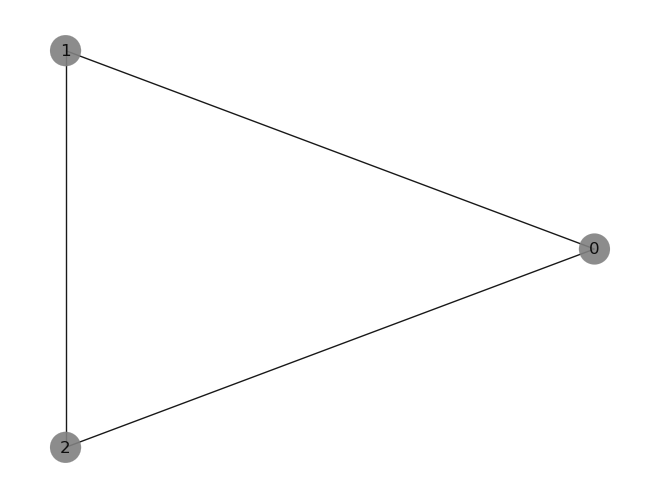

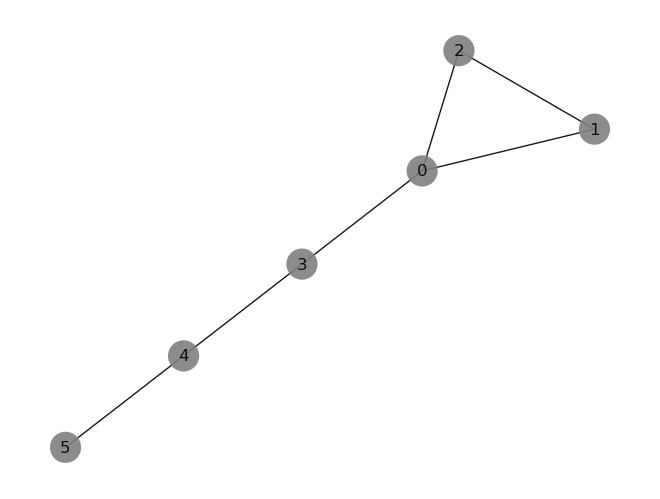

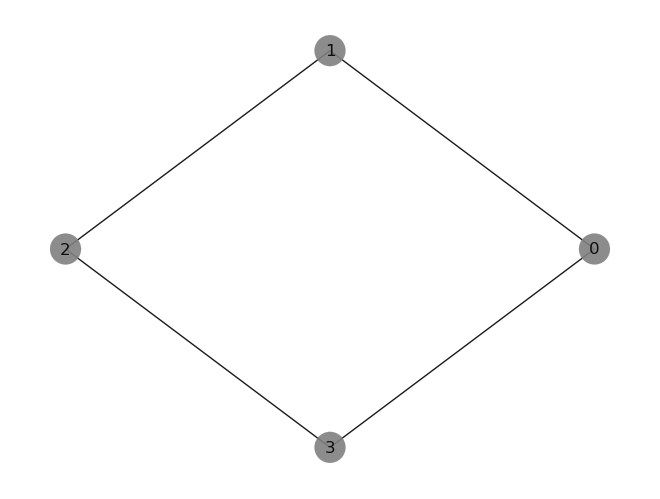

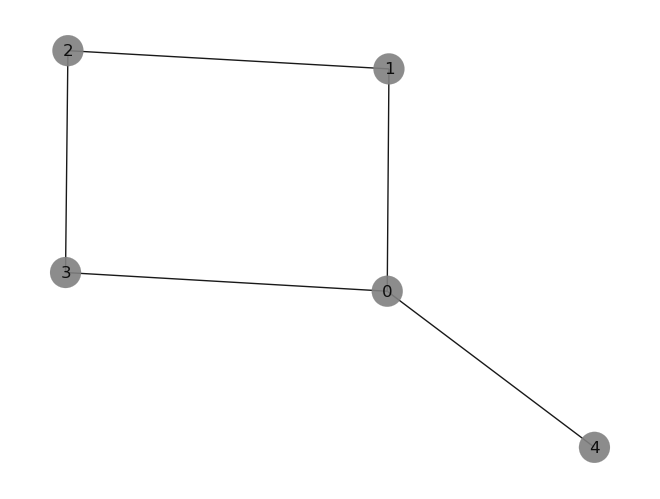

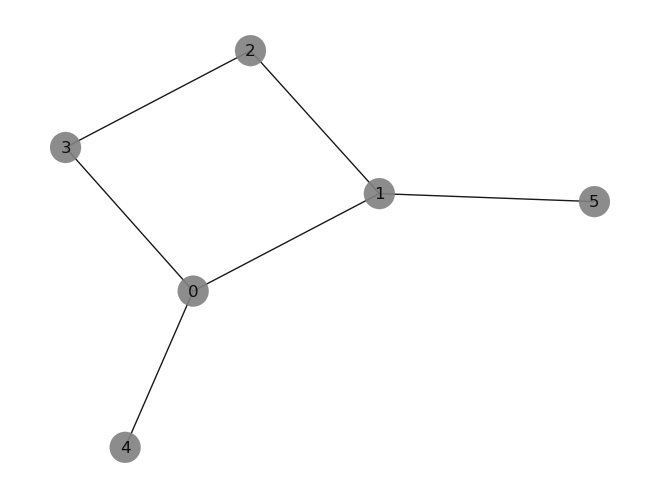

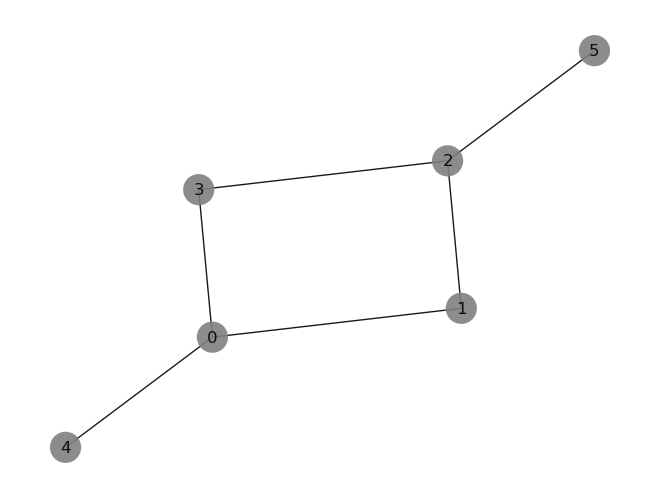

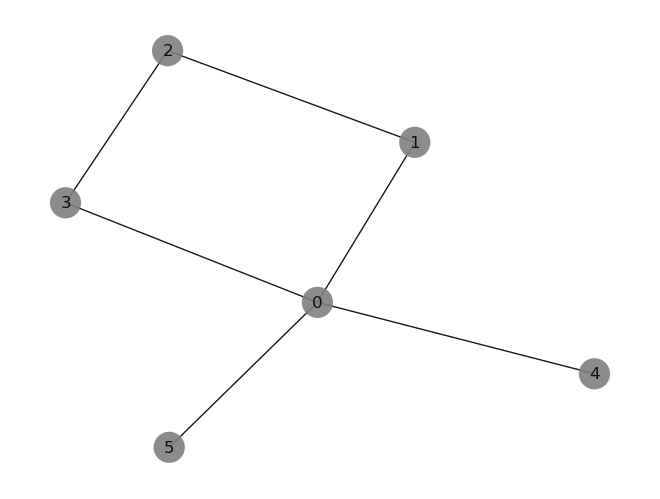

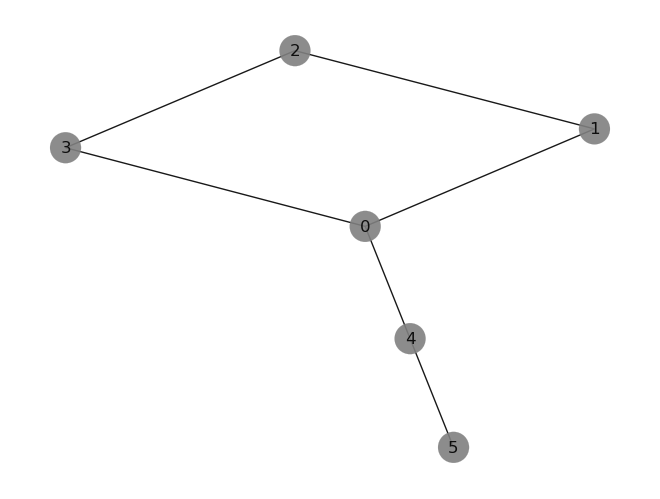

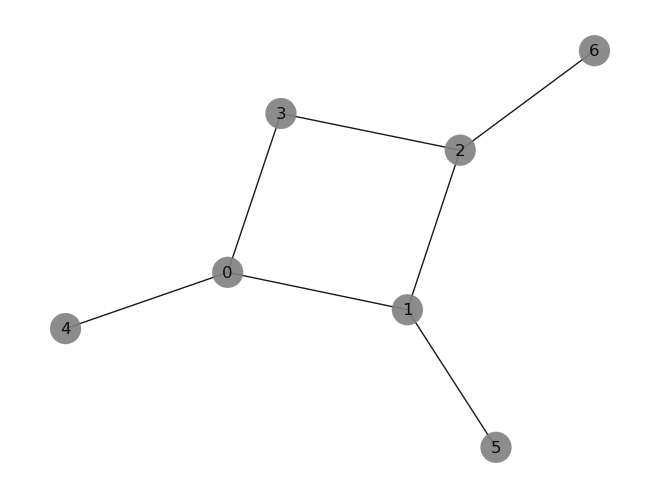

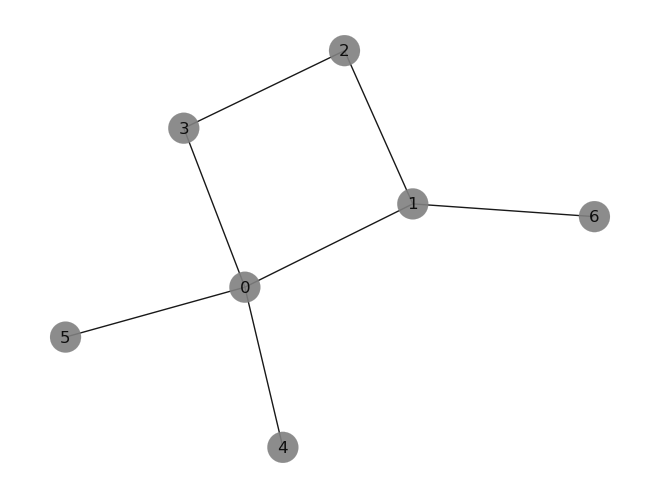

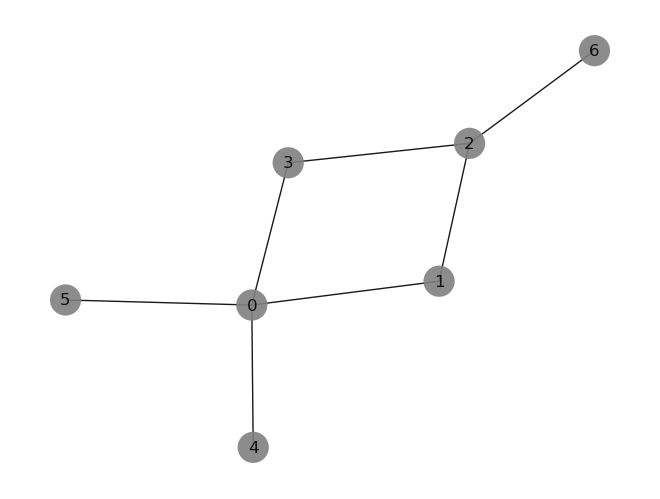

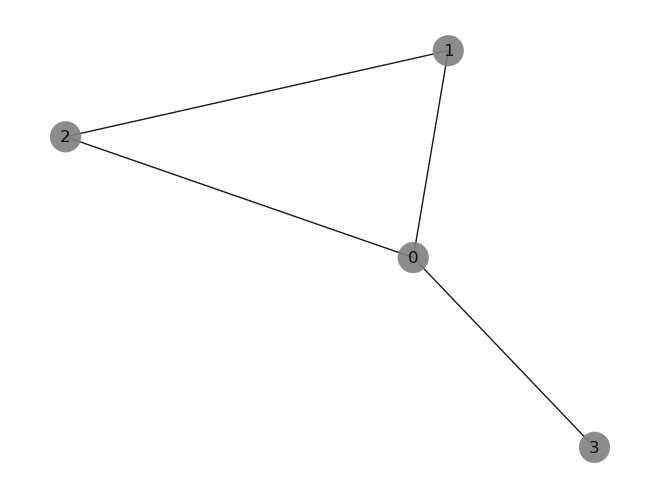

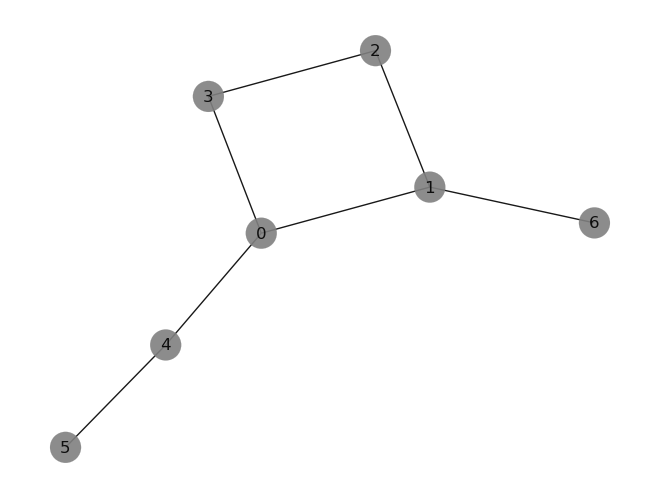

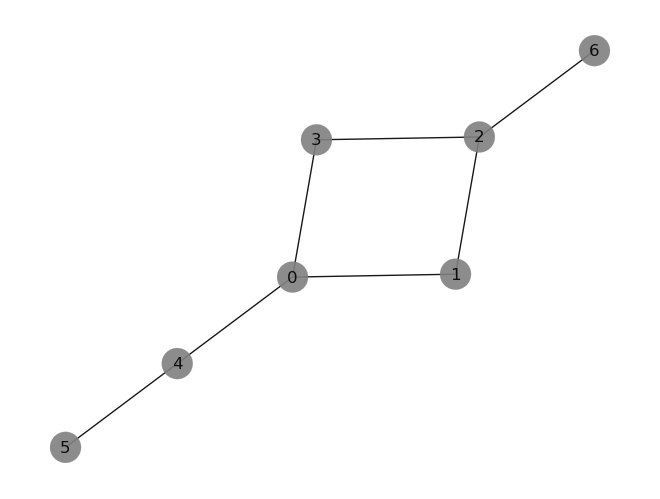

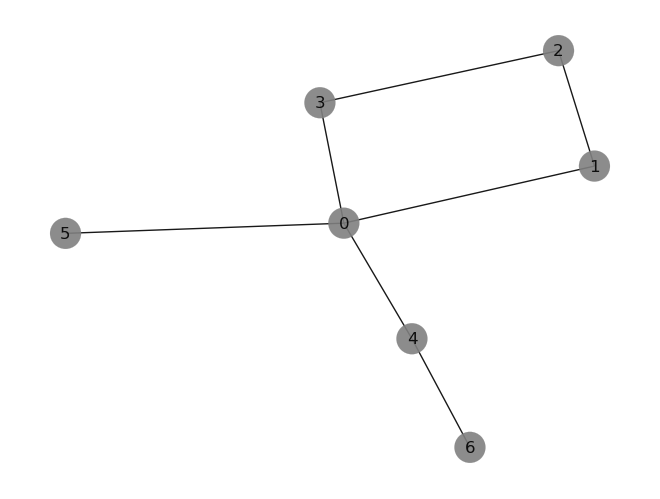

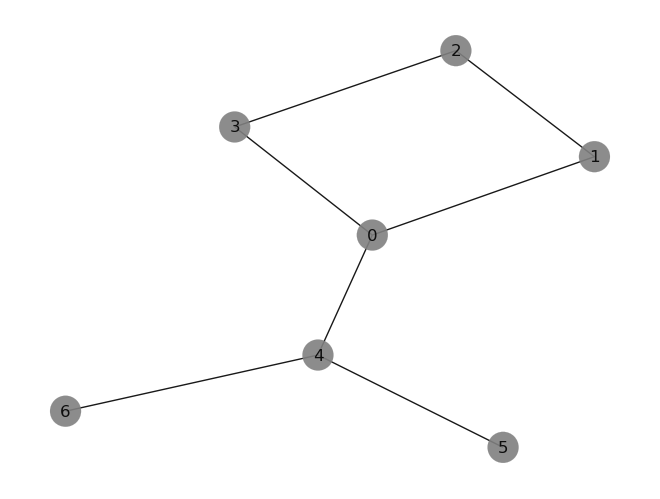

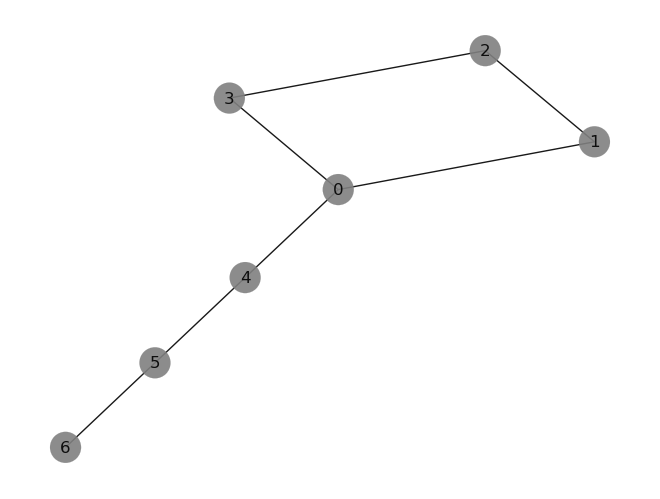

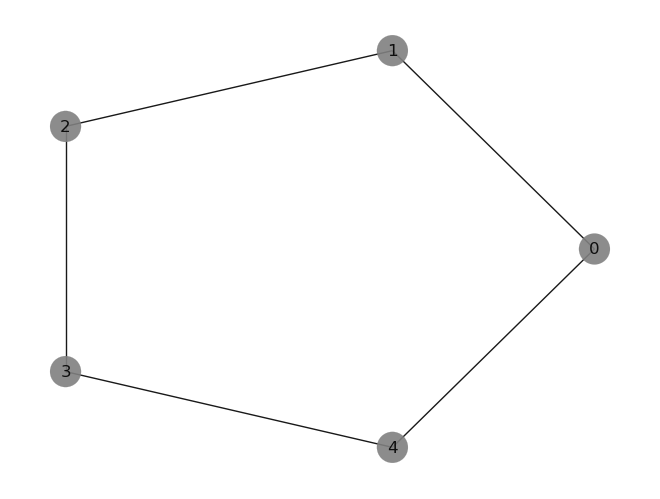

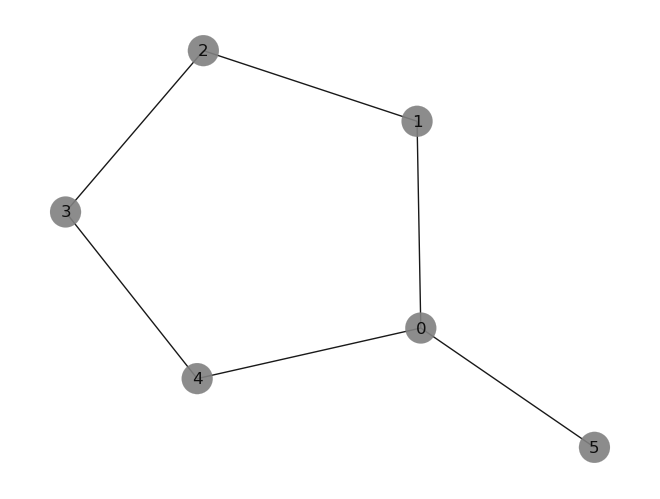

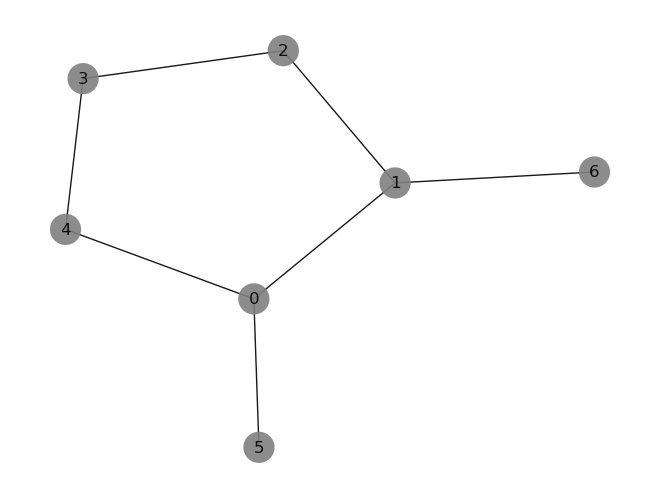

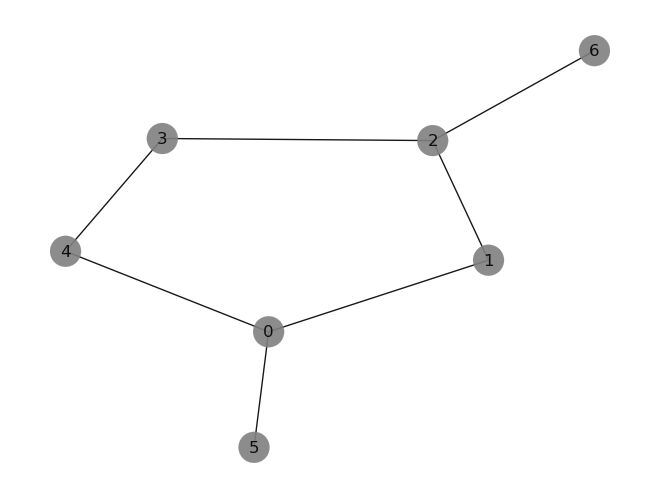

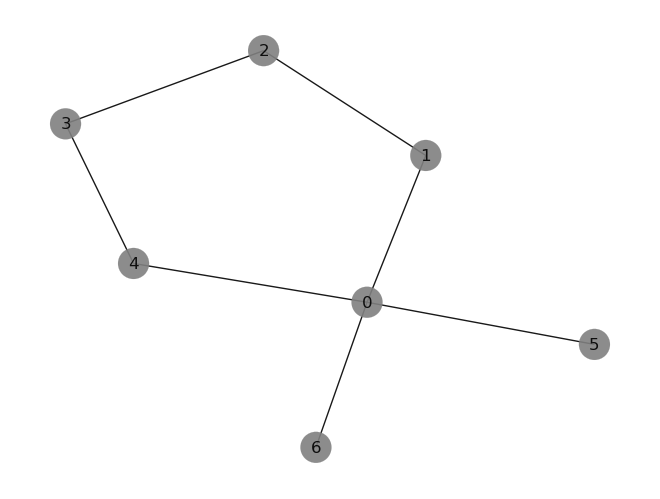

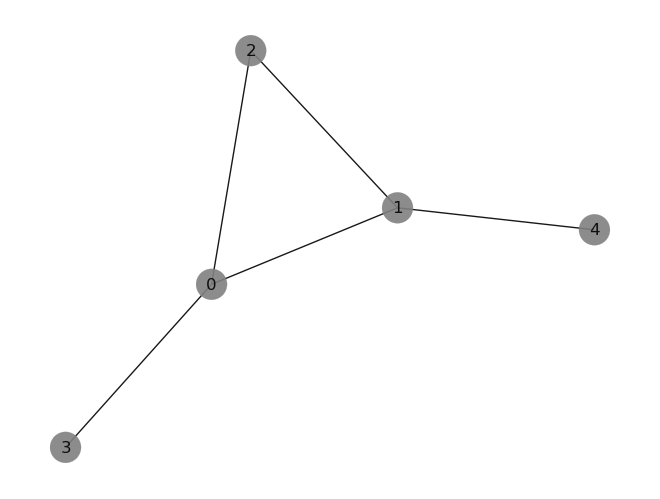

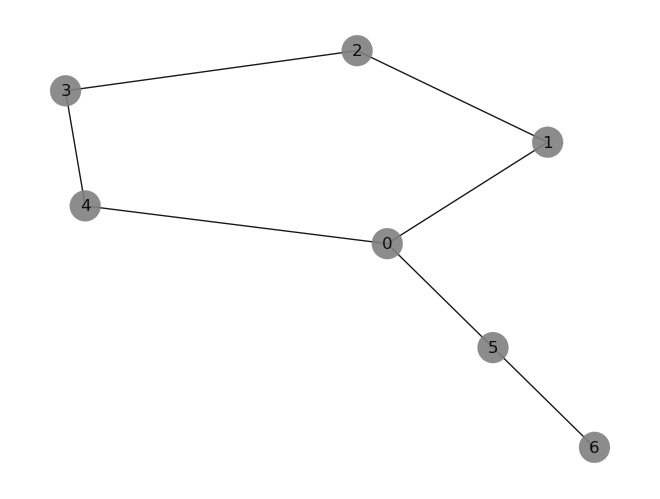

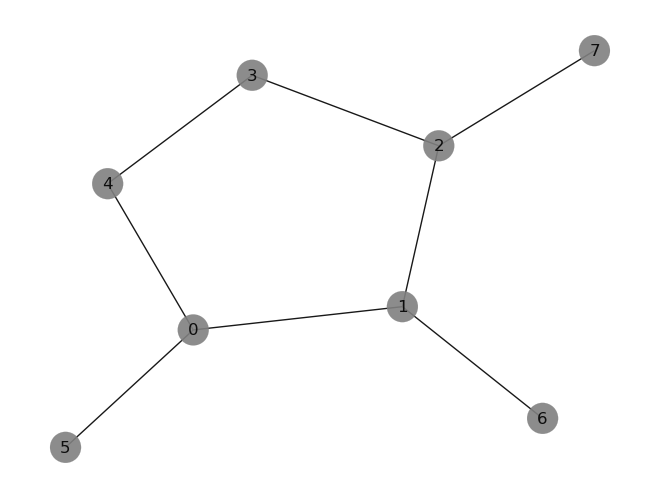

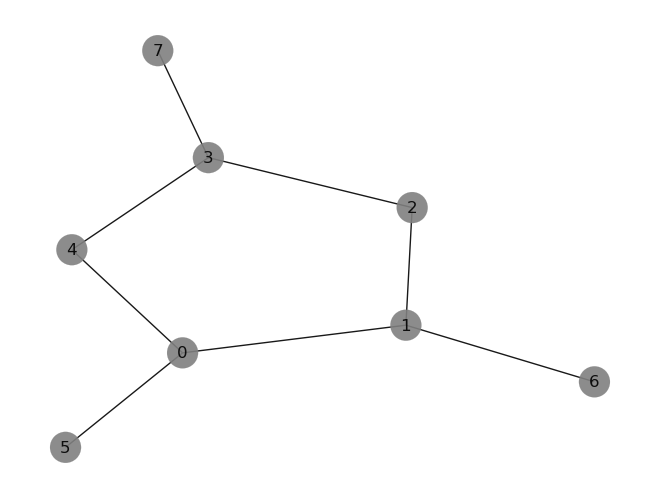

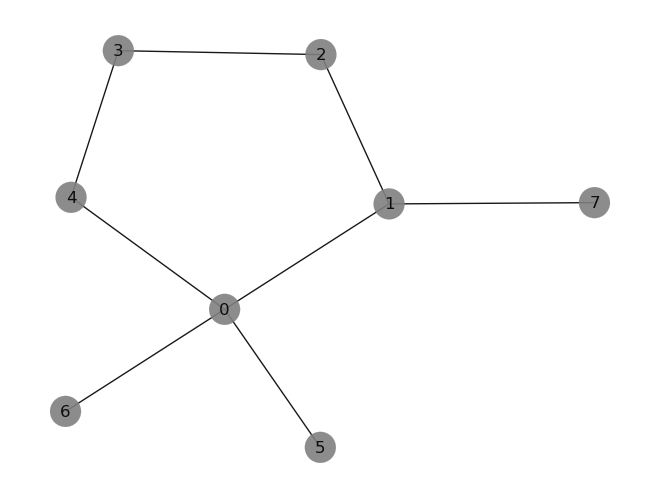

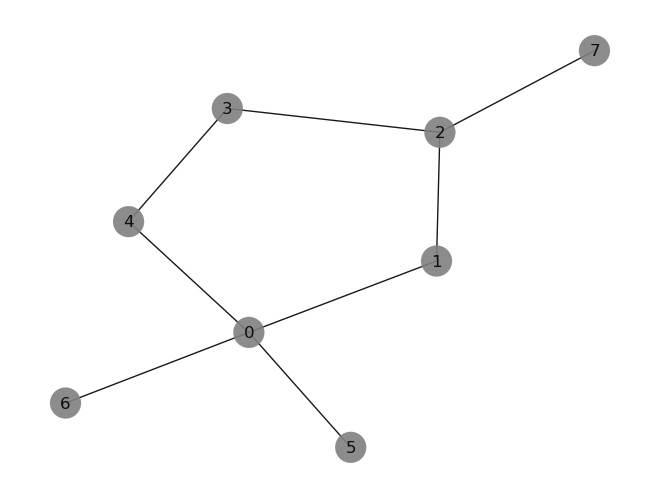

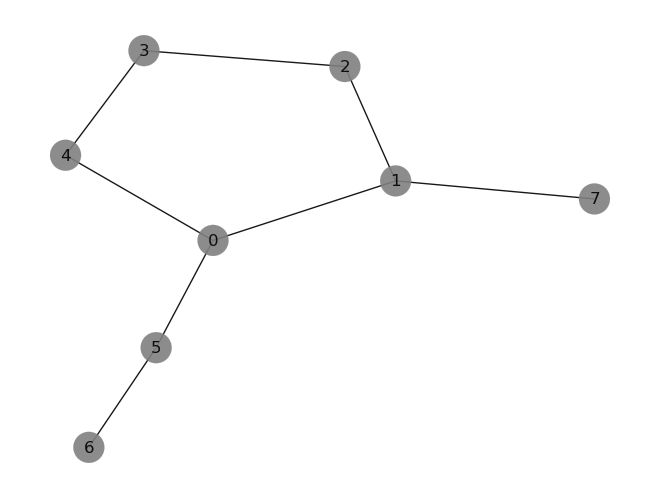

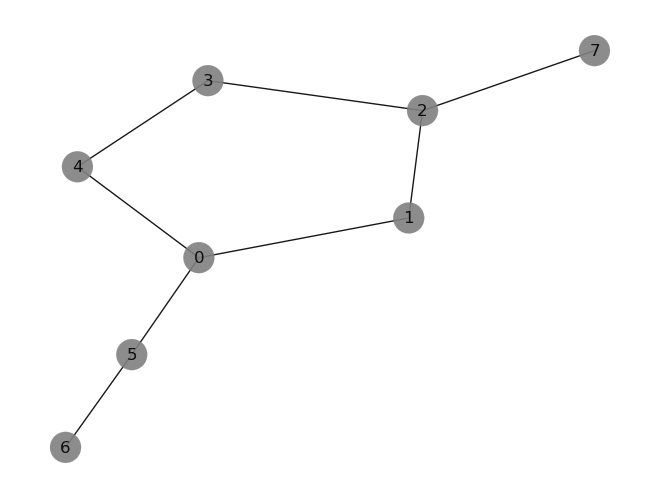

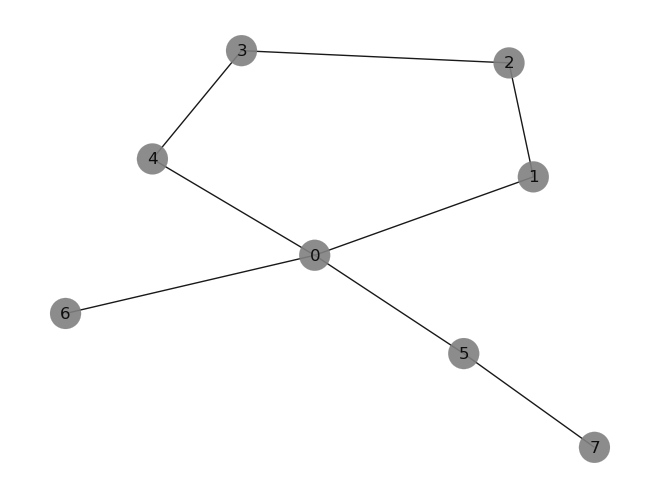

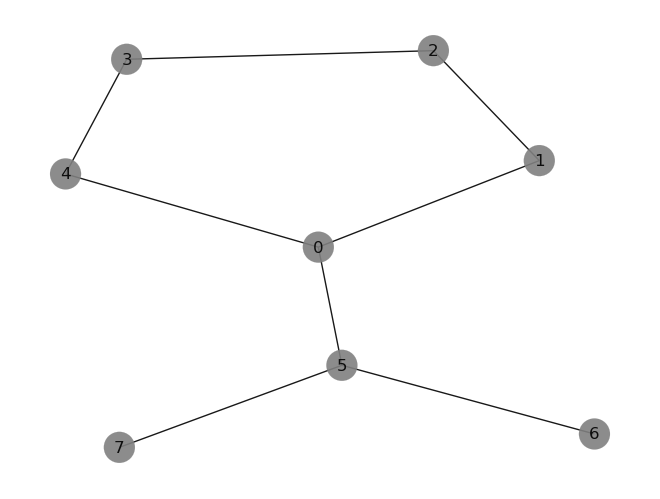

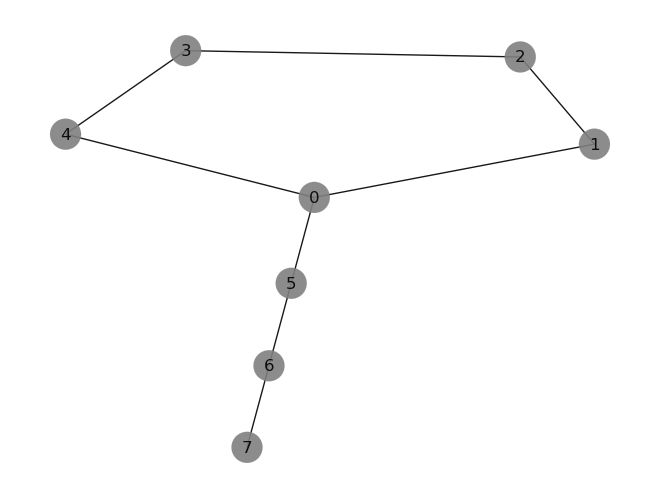

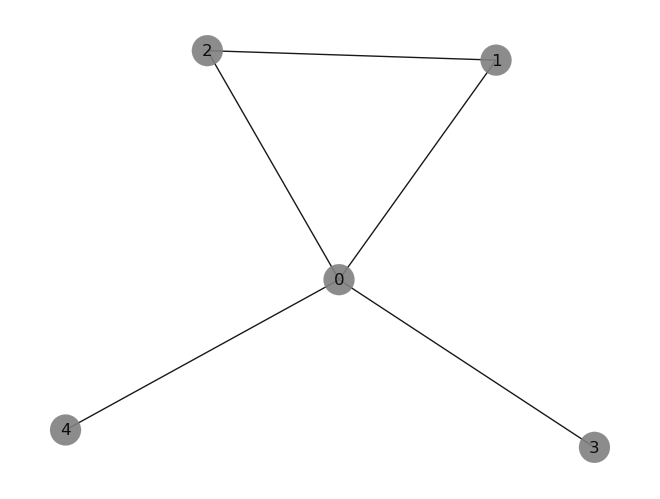

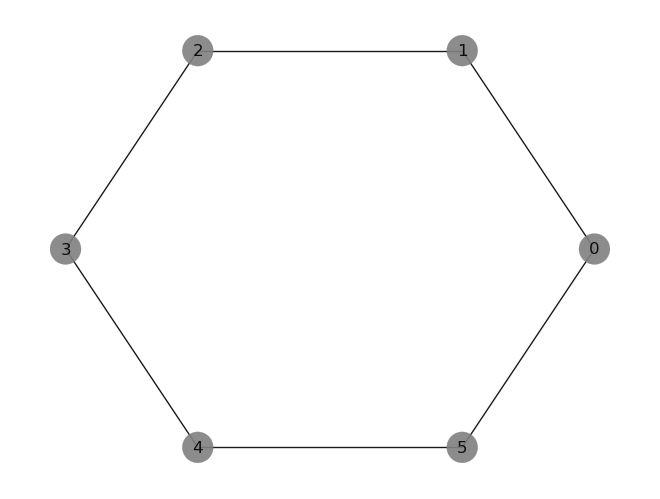

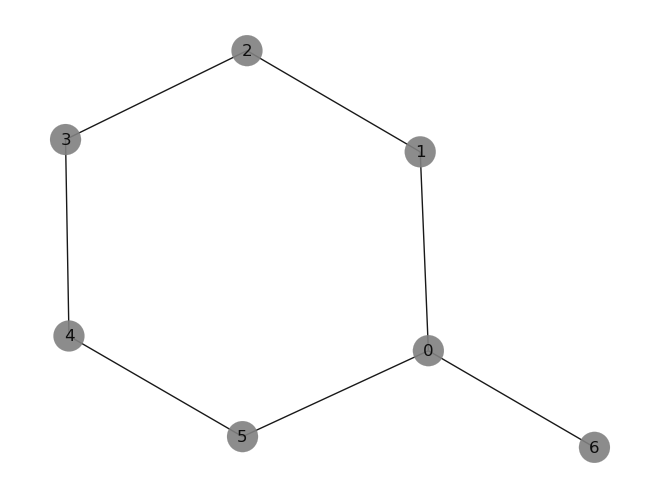

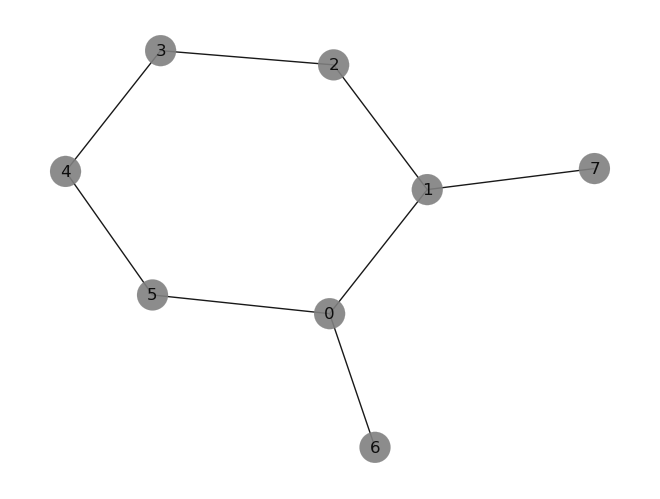

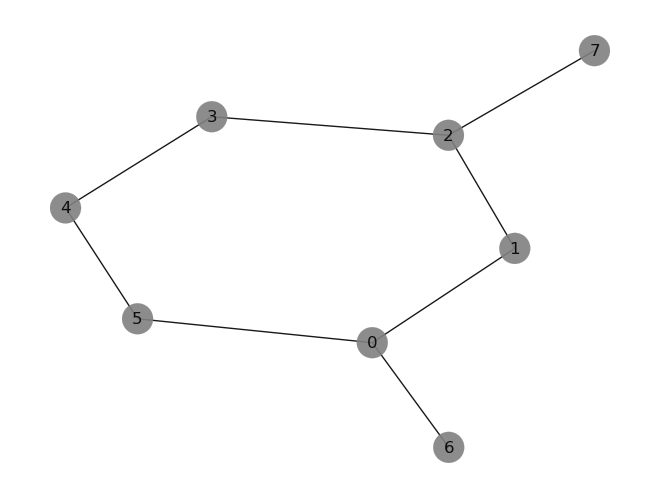

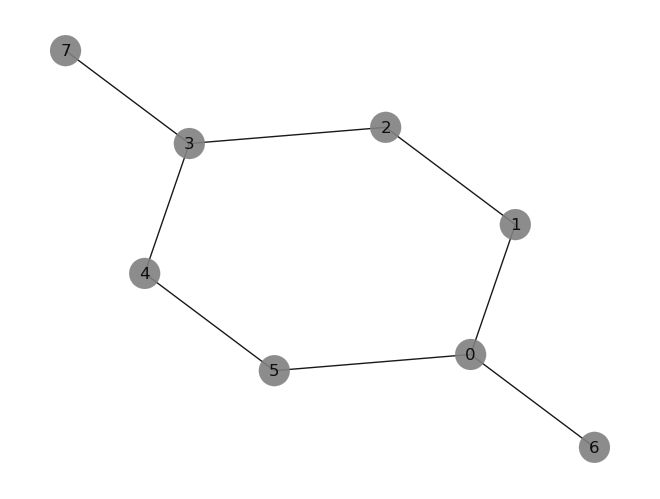

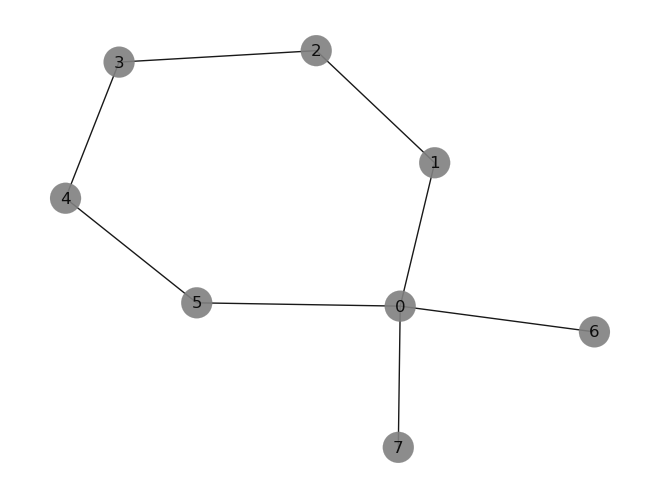

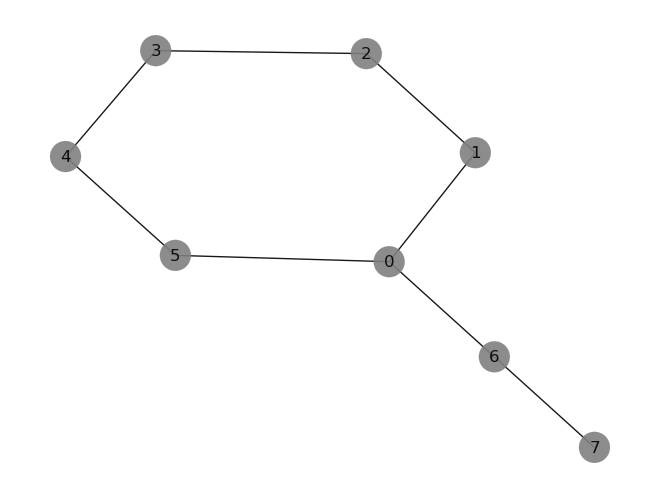

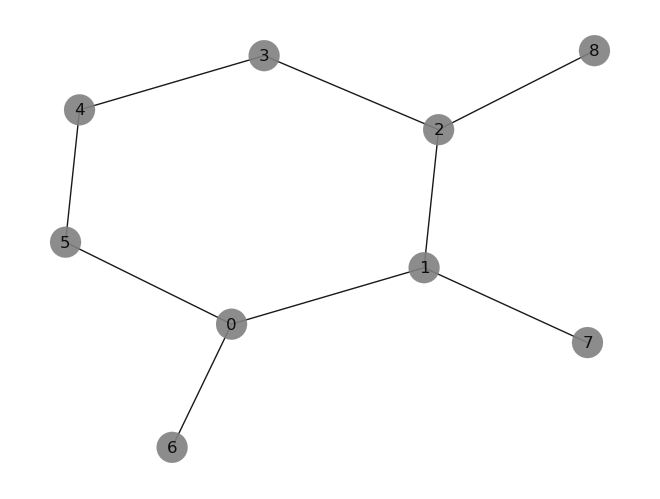

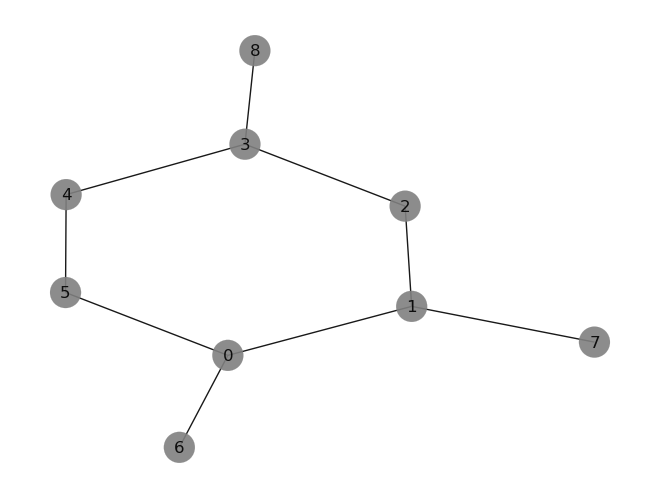

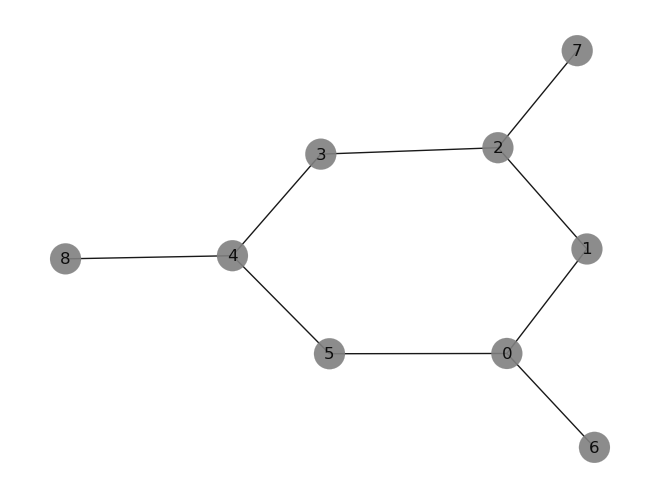

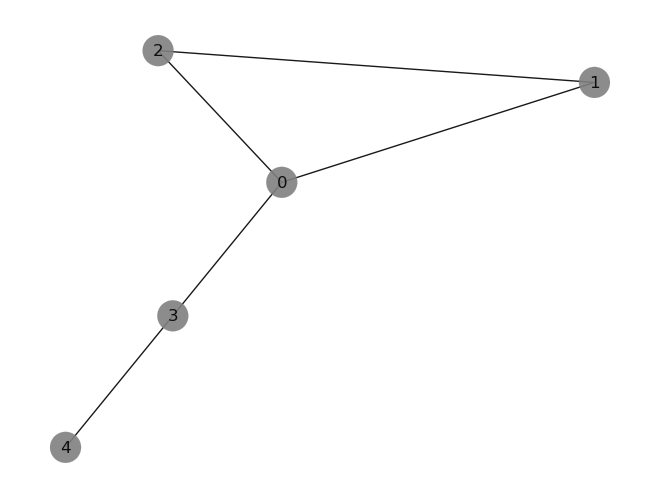

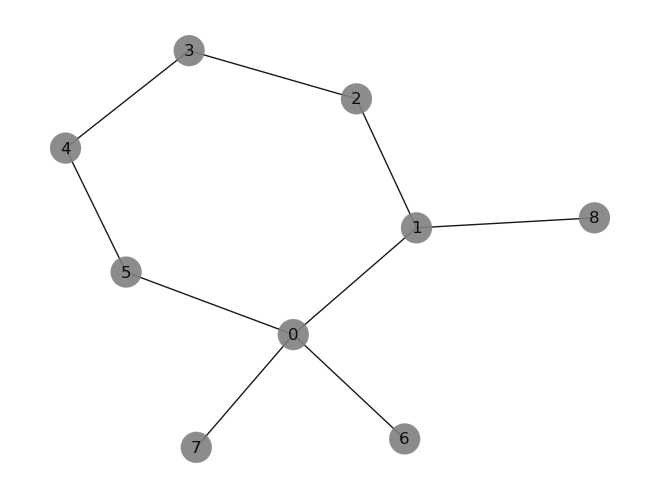

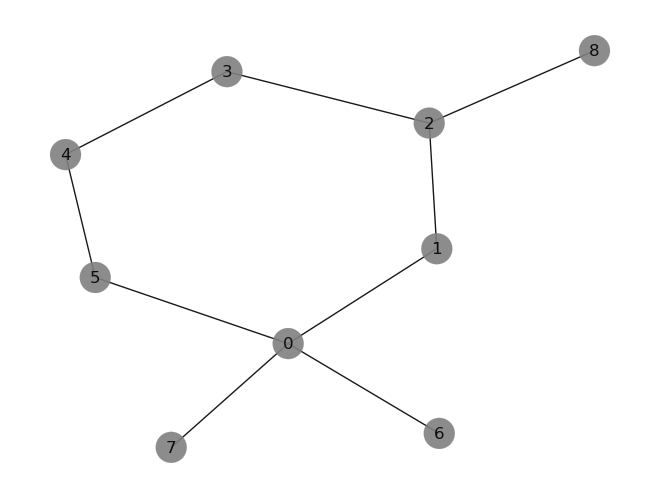

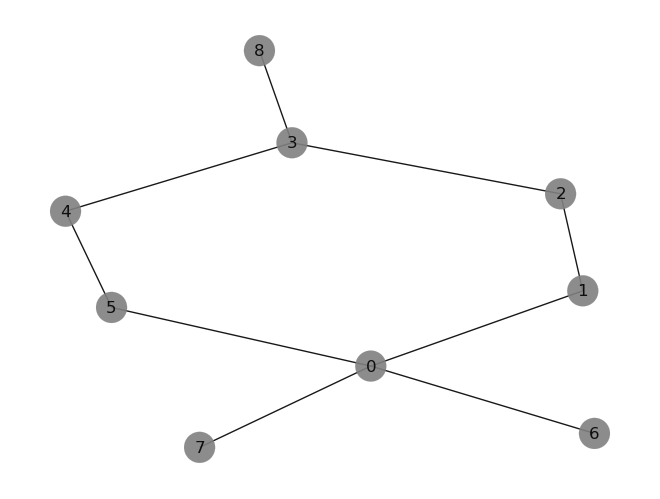

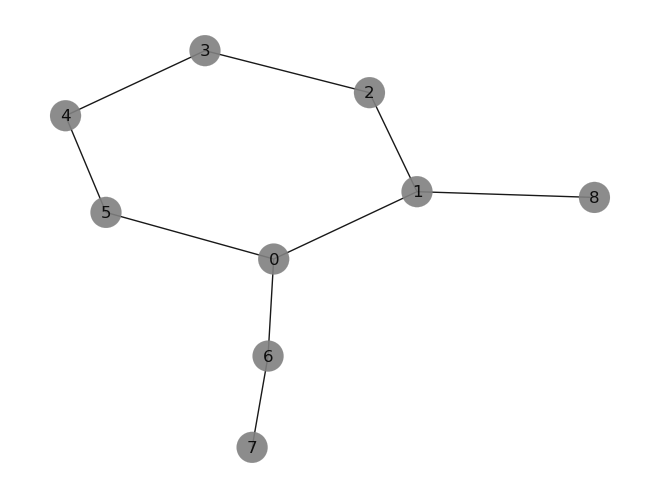

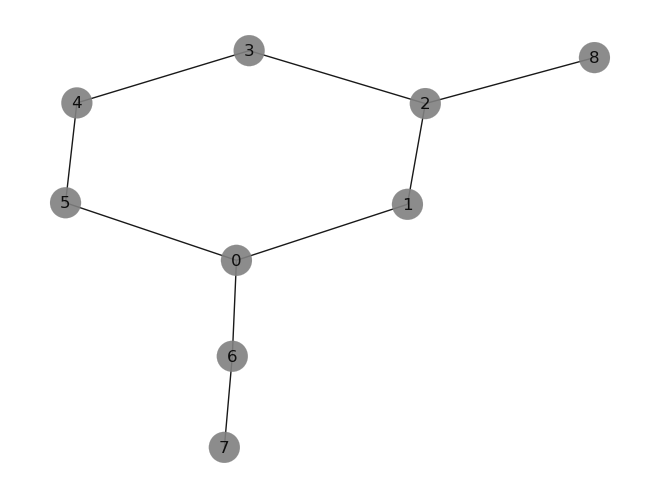

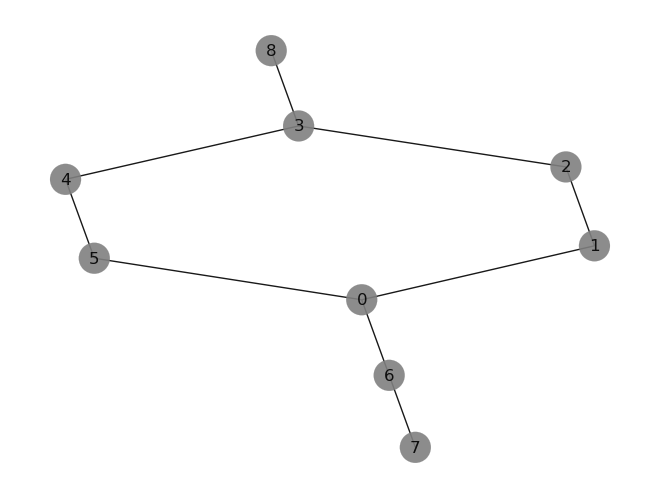

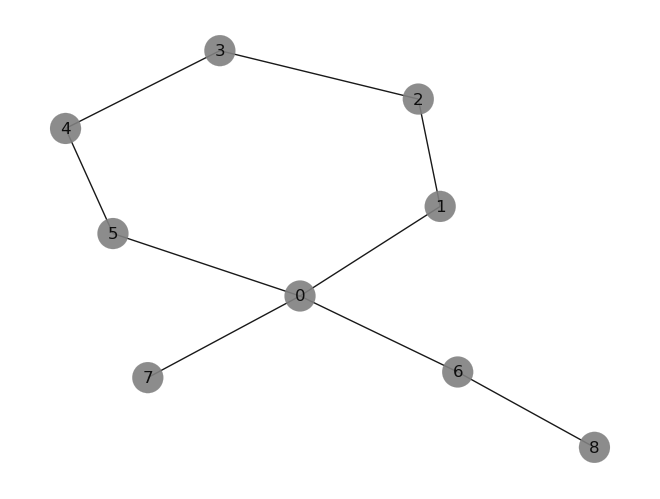

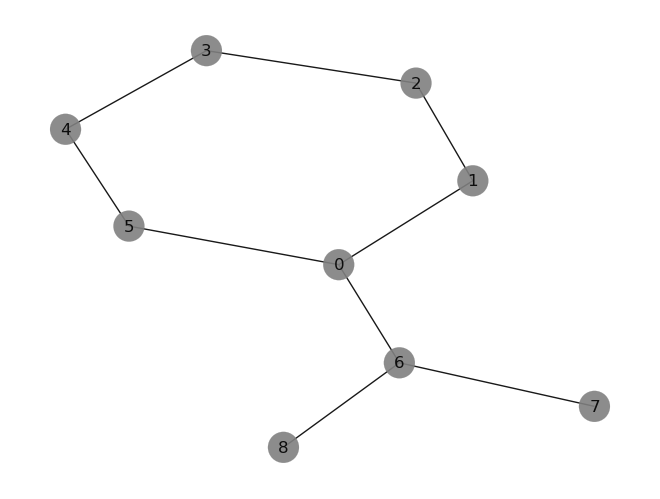

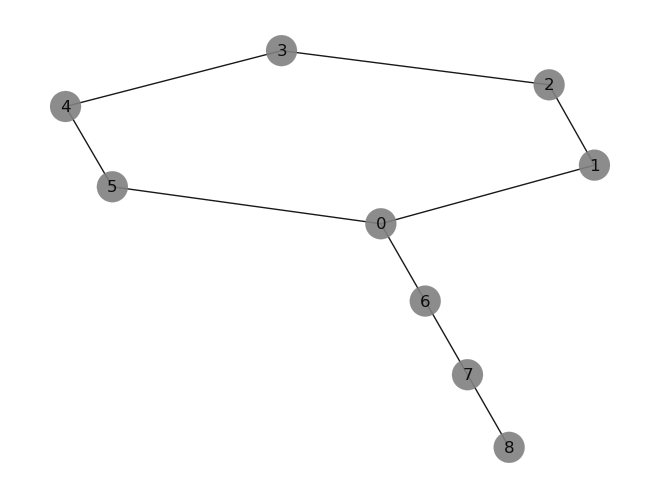

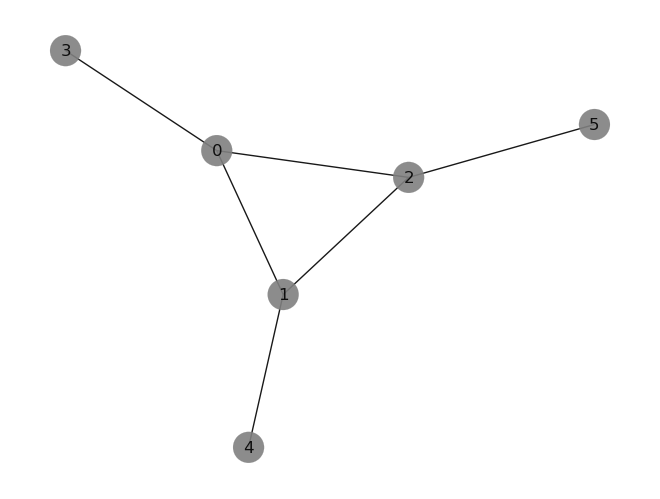

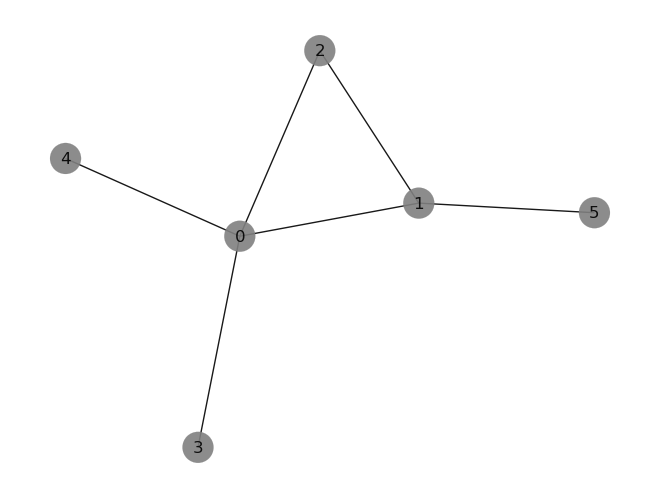

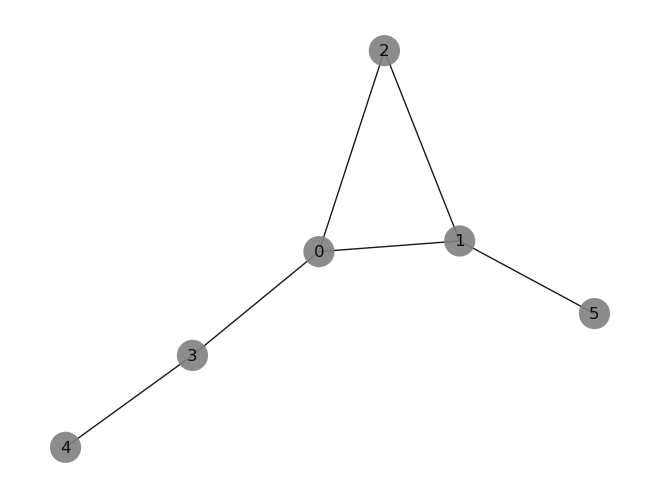

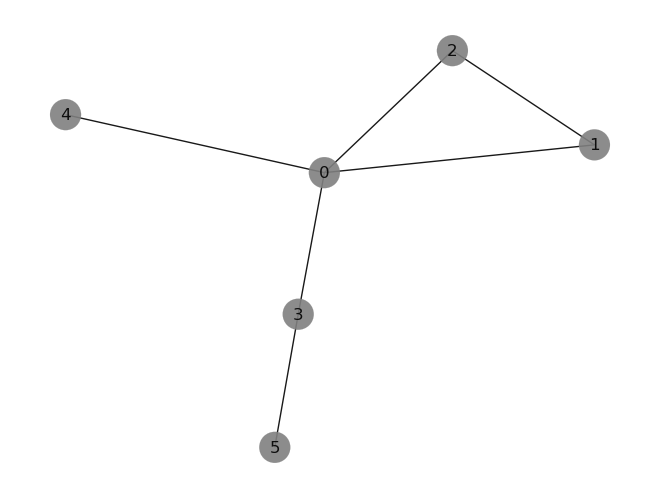

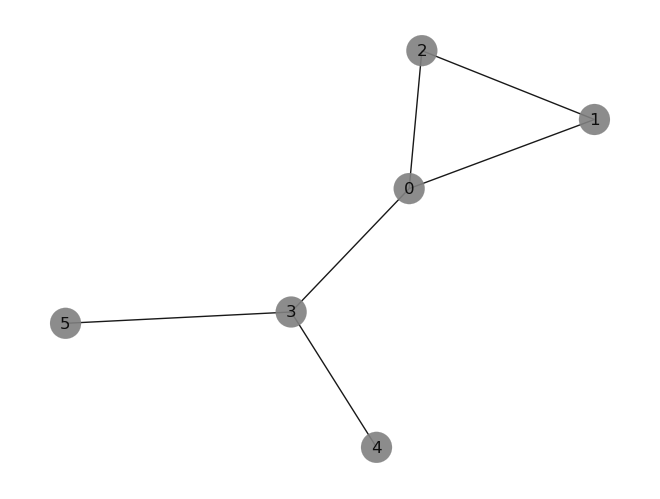

In [327]:
list_graph_files = sorted(os.listdir("data")[:])
graphs = [nx.read_gpickle(os.path.join("data", x)) for x in list_graph_files]

print(list_graph_files)
for graph in graphs:
  draw_graph(graph)
  plt.show()

In [ ]:
# Tổng node trong vòng * 10 + tổng node ở branch * 0.1

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!zip -r graph_data.zip data labels.pkl
!cp graph_data.zip "/content/drive/MyDrive/Thesis/Data"

In [ ]:
!cp "/content/drive/MyDrive/Thesis/Data/graph_data.zip" ./graph_data.zip 
!unzip graph_data.zip

Vong 3: 
1-1-(1|2|3) = 3->5
Nhanh: 2
1-1